# Predicting RGB values of RF patches


## imports


In [13]:
import math
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.fft as fourier
import pyspike as spk
import scipy.io as sio
import pandas
import matlab.engine
import cv2 as cv
import math
from numba import njit, prange
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import antropy as ent
import sklearn.metrics as metrics
import random
import scipy.stats as stats
import skimage.color as color_tools
import nitime.algorithms as tsa

In [14]:
matlab_needed=False
if matlab_needed:
    sessions=matlab.engine.find_matlab()
    engine=[]
    if len(sessions)==0:
        engine=matlab.engine.start_matlab()
    else:
        engine=matlab.engine.connect_matlab(sessions[-1])
    engine.addpath('D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\natural_images_code\\NaturalImagesGammaProject\\programs',nargout=0)

# Loader functions

In [15]:
def loadlfpInfo(folderLFP):
    x = sio.loadmat(os.path.join(folderLFP, 'lfpInfo.mat'))
    analogChannelsStored = np.squeeze(x["analogChannelsStored"])-1
    goodStimPos = np.squeeze(x["goodStimPos"])-1
    timeVals = np.squeeze(x["timeVals"])
    analogInputNums = []
    if 'analogInputNums' in x:
        analogInputNums = np.squeeze(x["analogInputNums"])
    return [analogChannelsStored, timeVals, goodStimPos, analogInputNums]


def loadspikeInfo(folderSpikes):
    fileName = os.path.join(folderSpikes, 'spikeInfo.mat')
    try:
        x = sio.loadmat(fileName)
        return [np.squeeze(x["neuralChannelsStored"]-1), np.squeeze(x["SourceUnitID"])]
    except FileNotFoundError:
        print('No spikeInfo.mat found in', folderSpikes)
        return [[], []]

def loadParameterCombinations(folderExtract=None):
    p = sio.loadmat(os.path.join(folderExtract, 'parameterCombinations.mat'))
    # subtract one from indices bcos matlab->python
    p["parameterCombinations"] = p["parameterCombinations"] - 1
    p["fValsUnique"] = p["fValsUnique"] - 1
    if 'sValsUnique' not in p:
        p['sValsUnique'] = p["rValsUnique"] / 3
    if 'cValsUnique' not in p:
        p['cValsUnique'] = 100
    if 'tValsUnique' not in p:
        p['tValsUnique'] = 0
    return p


def change_reference(analogData,folderLFP, referenceChannelString=None):
    if referenceChannelString is not None:
        if referenceChannelString == 'AvgRef':
            print('Changing to average reference')
            return analogData-np.squeeze(sio.loadmat(os.path.join(folderLFP, 'AvgRef.mat'))["analogData"])
        else:
            print('Changing to bipolar reference')
            return analogData- np.squeeze(sio.loadmat(os.path.join(folderLFP, referenceChannelString))["analogData"])
    return analogData


def get_bad_trials(badTrialFileName=None, useCommonBadTrialsFlag=True, channelString=None):
    badTrials = []
    allBadTrials = []

    if os.path.isfile(badTrialFileName):
        x = sio.loadmat(badTrialFileName)
        badTrials = np.squeeze(x["badTrials"])-1
        if "allBadTrials" in x:
            allBadTrials = np.squeeze(x["allBadTrials"])-1
        else:
            allBadTrials = badTrials

    if not useCommonBadTrialsFlag:
        badTrials = allBadTrials[channelString[5:]]-1
    print(str(len(badTrials)), ' bad trials')

    return badTrials, allBadTrials


In [16]:
subjectName = "alpaH"
expDate = "240817"
protocolName = "GRF_002"
imageFolderName ='ImagesTL'
folderSourceString = 'D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\natural_images_code\\NaturalImagesGammaProject'
gridType="Microelectrode"
gridLayout=2,
badTrialNameStr=''


# get the folder names
folderName = os.path.join(folderSourceString, 'data', subjectName, gridType, expDate, protocolName)
folderExtract = os.path.join(folderName, 'extractedData')
folderSegment = os.path.join(folderName, 'segmentedData')
folderLFP = os.path.join(folderSegment, 'LFP')
folderSpikes = os.path.join(folderSegment, 'Spikes')
rawImageFolder = os.path.join(folderSourceString,'data','images',imageFolderName)
# standardised parameters
blRange = np.array([-0.25, 0])
stRange = np.array([0.25, 0.5])

# load    Spike and LFP    Information
[analogChannelsStored, timeVals, goodStimPos, analogInputNums] = loadlfpInfo(folderLFP)
[neuralChannelsStored, sourceUnitIDs] = loadspikeInfo(folderSpikes)
timeVals_blSt=timeVals[np.logical_and(timeVals>=blRange[0],timeVals<=stRange[-1])]
# Get RF details
rfData = sio.loadmat(os.path.join(folderSourceString, 'data', 'rfData', subjectName, subjectName + gridType + 'RFData.mat'))
# work with only high RMSE electrodes
highRMSElectrodes = np.squeeze(rfData['highRMSElectrodes'])-1

# work only with sorted units
sortedPos = np.argwhere(sourceUnitIDs == 1)
sourceUnitIDs = sourceUnitIDs[sortedPos]
spikeChannels = np.squeeze(neuralChannelsStored[sortedPos])

referenceChannelString = None
plotColor = 'k'
analogChannels = np.setdiff1d(analogChannelsStored, highRMSElectrodes)
#define a commonArgs dictionary for all the plots
best_electrodes= np.squeeze(np.intersect1d(highRMSElectrodes[:-3],spikeChannels))
best_electrode_names=['elec' + str(i+1) for i in best_electrodes]
channelPos_names=[str(i) +", SID 1" for i in best_electrodes]
channelNumber = best_electrodes
stimValsToUse = np.array([i for i in range(32)])
numStimulus=stimValsToUse.shape[0]
numElectrodes=channelNumber.shape[0]
channelNumber = best_electrodes
kwargs={"folderName":folderName , "timeVals":timeVals, "plotColor":plotColor,
                    "blRange":blRange, "stRange":stRange, "referenceChannelString":referenceChannelString,
                    "badTrialNameStr":badTrialNameStr}

In [17]:
rfStats =np.squeeze( sio.loadmat(os.path.join(folderSourceString,'data','rfData',subjectName,subjectName +'Microelectrode' +'RFData.mat'))['rfStats'])


# LFP and Spike stuff

In [18]:
def get_LFP_spectrum(plotHandles=None, channelString=[], stimulus_list=None, folderName=None, analysisType=None,
                     timeVals=None, plotColor=None, blRange=None, stRange=None, referenceChannelString=None,
                     badTrialNameStr=None, useCommonBadTrialsFlag=True, NW=1, **kwargs):
    # first we have to unpack common args

    # calculate the sampling frequency

    Fs = int(1 / (timeVals[1] - timeVals[0]))
    # preliminary checks
    if int(np.diff(blRange) * Fs) != int(np.diff(stRange) * Fs):
        print('baseline and stimulus ranges are not the same')
        if analysisType >= 4:
            return
    elif analysisType == 2 or analysisType == 3:
        print('Use plotSpikeData instead of plotLFPData...')
        return

    # get folder names
    folderExtract = os.path.join(folderName, 'extractedData')
    folderSegment = os.path.join(folderName, 'segmentedData')
    folderLFP = os.path.join(folderSegment, 'LFP')

    numPlots = np.size(stimulus_list, 0)
    plot = plotHandles is not None
    numElectrodes = len(channelString)

    # get the stimulus shown
    parameterCombinations = loadParameterCombinations(folderExtract)['parameterCombinations']
    signal = np.zeros(numElectrodes, dtype=object)
    for i in range(numElectrodes):
        # Get Signal
        analogData = np.squeeze(sio.loadmat(os.path.join(folderLFP, channelString[i]))["analogData"])
        # Change Reference
        analogData = change_reference(analogData, folderLFP, referenceChannelString)
        signal[i] = analogData
    # Get bad trials
    badTrialFileName = os.path.join(folderSegment, 'badTrials' + badTrialNameStr + '.mat')
    badTrials, allBadTrials = [np.squeeze(i) for i in
                               get_bad_trials(badTrialFileName, useCommonBadTrialsFlag, channelString)]
    # find baseline period stimulus period etc
    rangePos = int(np.diff(blRange) * Fs)
    blPos = np.arange(0, rangePos) + np.argmax(timeVals >= blRange[0])
    stPos = np.arange(0, rangePos) + np.argmax(timeVals >= stRange[0])


    result = np.zeros((numPlots, numElectrodes), dtype=object)
    if analysisType == 6:
        result = np.zeros((numPlots, numElectrodes, 3, 251))

    for i in range(numPlots):
        # get the good trials for each stimulus by removing the bad trials
        goodPos = np.setdiff1d(parameterCombinations[0, 0, 0, stimulus_list[i]], badTrials)
        if goodPos is None:
            print('No entries for this combination..')
            continue
        for j, electrode in enumerate(channelNumber):
            print('image', str(stimulus_list[i]), ', n=', str(electrode))
            analogData = signal[j]
            if analysisType == 1:
                # plot the Evoke response i.e LFP vs time
                erp = np.mean(analogData[goodPos], 0)
                if plot:
                    plotHandles[i].plot(timeVals, erp, 'color', plotColor)
                result[i][j] = [erp]


            elif analysisType == 4 or analysisType == 5:
                # plot the mean of FFT of trials

                fftBL = abs(fourier.fft(analogData[goodPos][:, blPos], axis=1))
                fftST = abs(fourier.fft(analogData[goodPos][:, stPos], axis=1))
                fVals = np.fft.fftfreq(len(fftBL), 1 / Fs)


                result[i][j] = np.array([fftBL, fftST, fVals])

            elif analysisType == 6 or analysisType == 7:
                # plot the spectogram of mean of trials
                x_bl=np.mean(analogData[goodPos][:, blPos], axis=0)
                x_st=np.mean(analogData[goodPos][:, stPos], axis=0)
                _,pow_bl,_=tsa.multi_taper_psd(x_bl, adaptive=False, jackknife=False,Fs=Fs,NW=NW)
                fvals,pow_st,_=tsa.multi_taper_psd(x_st, adaptive=False, jackknife=False,Fs=Fs,NW=NW)

                result[i][j] = np.array([pow_bl, pow_st, fvals])
    return np.array(result)


In [19]:
def custom_concat(array1):
    size=int(0)
    for i in array1:
        size+=i.size
    result=np.zeros(size,dtype=np.float64)
    index=int(0)
    for i in range(len(array1)):
        for j in range(len(array1[i])):
            result[index]=array1[i][j]
            index+=1
    return result

def get_spike_data(folderSpikes,channelNumber, unitID):
    return np.squeeze(sio.loadmat(os.path.join(folderSpikes, 'elec' + str(channelNumber+1) + '_SID' + str(unitID) + '.mat'))[
        "spikeData"])

def getPSTH_forp(X,tRange,d=0.001,Ntrials=1,smoothSigmaMs=None):
    if d>=1:
        d=d/1000

    spk = np.sort(X)

    #select only those values which lie between tRange[0] and tRange[-1]

    ind1 = np.argwhere(spk>=tRange[0])[0][0]
    ind2 = -1
    try:
        ind2=np.argwhere(spk>=tRange[-1])[0][0]
    except:
        pass
    spk = spk[ind1:ind2]
    N = int((tRange[-1] - tRange[0]) / d)
    H=np.histogram(spk,bins=N,range=tRange)[0]
    timeVals = np.linspace(tRange[0] + d / 2, tRange[-1] - d / 2, num=N)
    # compute the PSTH
    psth=H/d/Ntrials
    # smooth the PSTH if requested
    return psth,timeVals

def plotSpikeData1Channel(plotHandles=None, channelNumber=None, stimulus_list=None, folderName=None, analysisType=None,
                          timeVals=None, plotColor='g', unitID=None,badTrialNameStr="", plot=False,bin_time=50):
    # plots the data for a single channel
    if unitID is None:
        unitID=np.ones(len(channelNumber),dtype=int)
    # get folder names
    folderExtract = os.path.join(folderName, 'extractedData')
    folderSegment = os.path.join(folderName, 'segmentedData')
    folderSpikes = os.path.join(folderSegment, 'Spikes')
    numPlots=len(stimulus_list)
    return_value=np.zeros((numPlots,len(channelNumber),2,int(((timeVals[-1]-timeVals[0])*1000)/bin_time)))
    # get the stimuli
    parameterCombinations = loadParameterCombinations(folderExtract)['parameterCombinations']
    badTrialFileName = os.path.join(folderSegment
                                    , 'badTrials' + badTrialNameStr + '.mat')
    badTrials, allBadTrials = [np.squeeze(i) for i in
                               get_bad_trials(badTrialFileName)]
    # get the spike data
    spikeData = {i:get_spike_data(folderSpikes,channelNumber[i],unitID[i]) for i in range(len(channelNumber))}

    for i in range(numPlots):
        goodPos = np.squeeze(np.setdiff1d(parameterCombinations[0, 0, 0, stimulus_list[i]], badTrials))
        Ntrials= len(goodPos)
        for j,electrode in enumerate(channelNumber):
            # get the good trials for each stimulus by removing the bad trials
            data=custom_concat(spikeData[j][goodPos])
            if goodPos is None:
                print('No entries for this combination..')
                continue
            print('image', str(stimulus_list[i]), ', electrode=', str(electrode))

            if analysisType == 2:
                return_value[i][j]=getPSTH_forp(data,timeVals,d=bin_time,Ntrials=Ntrials)
                if plot:
                    pass
            elif analysisType == 1:
                # Raster Plot
                X = spikeData[goodPos]
                if plot:
                    plotHandles[i].eventplot(X, colors='k')
                return X
    return np.array(return_value)
best_electrodes= np.squeeze(np.intersect1d(highRMSElectrodes[:-3],spikeChannels))

In [21]:
def getImageInDegrees(inputImage, monitorSpecifications, viewingDistanceCM):
    viewingDistance = viewingDistanceCM / 2.54
    yDeg = (math.atan((monitorSpecifications["height"] / 2) / viewingDistance)) * 180 / math.pi
    xDeg = (math.atan((monitorSpecifications["width"] / 2) / viewingDistance)) * 180 / math.pi
    imageXRes = inputImage.shape[1]
    imageYRes = inputImage.shape[0]
    if monitorSpecifications["xRes"] != imageXRes or monitorSpecifications["yRes"] != imageYRes:
        raise Exception("Image resolution does not match monitor resolution")
    xAxisDeg = np.arange(-xDeg, xDeg, (2 * xDeg / imageXRes))[:imageXRes]
    yAxisDeg = np.arange(-yDeg, yDeg, (2 * yDeg / imageYRes))[:imageYRes]
    return [xAxisDeg, yAxisDeg]

def get_min_max_range(rfStatistics,electrodelist,RFtype='ellipse',monitorSpecifications=None,viewingDistanceCM=50,imageDims=[720,1280,3]):

    numElectrodes = len(electrodelist)
    if monitorSpecifications is None:
        monitorSpecifications = {"height": 11.8, "width": 20.9, "xRes": 1280, "yRes": 720}
    inputImage=np.zeros(shape=imageDims)
    [xAxisDeg, yAxisDeg] = getImageInDegrees(inputImage, monitorSpecifications,viewingDistanceCM)
    xResDeg = xAxisDeg[1] - xAxisDeg[0]
    yResDeg = yAxisDeg[1] - yAxisDeg[0]
    xCenterPos=np.zeros(numElectrodes)
    yCenterPos=np.zeros(numElectrodes)
    sigma_x=np.zeros(numElectrodes)
    sigma_y=np.zeros(numElectrodes)
    for j in range (numElectrodes):
            rfTMP = rfStatistics[electrodelist[j]]
            mAzi = np.squeeze(rfTMP["meanAzi"])
            mEle = np.squeeze(rfTMP["meanEle"])
            xCenterPos[j] = int(np.argwhere(xAxisDeg >= mAzi)[0][0])
            yCenterPos[j] = int(np.argwhere(yAxisDeg >= -mEle)[0][0])
            if RFtype=="ellipse":
                    sigma_x[j]=np.squeeze(rfTMP["rfSizeAzi"]/xResDeg)
                    sigma_y[j]=np.squeeze(rfTMP["rfSizeEle"]/yResDeg)
    min_x,max_x,min_y,max_y=int(np.min(xCenterPos-sigma_x)-1),int(np.max(xCenterPos+sigma_x)+1),int(np.min(yCenterPos-sigma_y)-1),int(np.max(yCenterPos+sigma_y)+1)
    return {"xmin":min_x,"xmax":max_x,"ymin":min_y,"ymax":max_y}
ellipse_params=get_min_max_range(rfStats,best_electrodes,RFtype='ellipse')



@njit(parallel=True)
def twoDguassian(grid,x_0,y_0,sigma_x,sigma_y,A=1):
    for y_pix in prange(grid.shape[0]):
        for x_pix in prange(grid.shape[1]):
            x = x_pix - x_0
            y = y_pix - y_0
            grid[y_pix,x_pix] = np.exp(-((x**2)/(2*sigma_x**2) + (y**2)/(2*sigma_y**2)))
            if grid[y_pix,x_pix] <0.05:
                grid[y_pix,x_pix] = 0


@njit(parallel=True)
def twoDellipse(grid,x_0,y_0,sigma_x,sigma_y,A=1,x_min=0,x_max=1280,y_min=0,y_max=720):
    for y_pix in prange(y_min,y_max):
        for x_pix in prange(x_min,x_max):
            x = x_pix - x_0
            y = y_pix - y_0
            if  (x**2/sigma_x**2 + y**2/sigma_y**2) <= 1:
                grid[y_pix,x_pix] = A


def getImageData(hImagesPlot=None, hImagePatches=None, rawImageFolder="", fValsToUse=None, electrodeList=[1],
                 colorName='g', plottingDetails=None, rfStats=None, RFtype=None, crop_equal=True, monitorSpecifications=None, viewingDistanceCM=50, imageDims=(720,1280,3),tohsv=False):
    if monitorSpecifications is None:
        monitorSpecifications = {"height": 11.8, "width": 20.9, "xRes": 1280, "yRes": 720}
    patchSizeDeg = 2
    data = np.zeros(len(fValsToUse), dtype='object')
    ellipse_params=get_min_max_range(rfStats, electrodeList, RFtype=RFtype)
    x_min=ellipse_params["xmin"]
    x_max=ellipse_params["xmax"]
    y_min=ellipse_params["ymin"]
    y_max=ellipse_params["ymax"]
    if crop_equal:
        data=np.zeros(shape=(len(fValsToUse), len(electrodeList), y_max-y_min,x_max-x_min, 3))
    imageGrid=np.zeros(shape=imageDims)
    [xAxisDeg, yAxisDeg] = getImageInDegrees(imageGrid, monitorSpecifications, viewingDistanceCM)
    xResDeg = xAxisDeg[1] - xAxisDeg[0]
    yResDeg = yAxisDeg[1] - yAxisDeg[0]

    for j,electrode in enumerate(electrodeList):
        numElectrodes = len(electrodeList)
        if monitorSpecifications is None:
            monitorSpecifications = {"height": 11.8, "width": 20.9, "xRes": 1280, "yRes": 720}
        # min_x and min_y max_x max_y
        xPosToTake =int( patchSizeDeg // xResDeg)
        yPosToTake = int(patchSizeDeg // yResDeg)

        rfTMP = rfStats[electrodeList[j]]
        mAzi = np.squeeze(rfTMP["meanAzi"])
        mEle = np.squeeze(rfTMP["meanEle"])
        xCenterPos = int(np.argwhere(xAxisDeg >= mAzi)[0][0])
        yCenterPos = int(np.argwhere(yAxisDeg >= -mEle)[0][0])
        for i in range(len(fValsToUse)):
            imageFileName = os.path.join(rawImageFolder, 'Image' + str(fValsToUse[i] + 1) + '.png')
            inputImage = plt.imread(imageFileName)[:,:,:3]
            if tohsv:
                inputImage=color_tools.rgb2hsv(inputImage)
            if RFtype=="ellipse":
                xPosToTake1=np.squeeze(rfTMP["rfSizeAzi"]/xResDeg)
                yPosToTake1=np.squeeze(rfTMP["rfSizeEle"]/yResDeg)
                mask=np.zeros(shape=inputImage.shape[:-1])
                twoDellipse(mask,xCenterPos,yCenterPos,xPosToTake1,yPosToTake1)
                mask=np.stack([mask]*inputImage.shape[-1],axis=2)
                data[i][j] = np.multiply(inputImage, mask)[y_min:y_max,x_min:x_max]
            elif RFtype=="gaussian":
                xPosToTake1=np.squeeze(rfTMP["stdAzi"]/xResDeg)
                yPosToTake1=np.squeeze(rfTMP["stdEle"]/yResDeg)
                mask=np.zeros(shape=inputImage.shape[:-1])
                twoDguassian(mask,xCenterPos,yCenterPos,xPosToTake1,yPosToTake1)
                mask=np.stack([mask]*inputImage.shape[-1],axis=2)
                data[i][j]=np.multiply(inputImage,mask)[y_min:y_max,x_min:x_max]
            else:
                data[i][j] = inputImage[y_min:y_max,x_min:x_max]
    return data


In [22]:
savepath=folderSourceString+"\\python_data"
reload=False
resave=True
[imagePatches,imagePatches_e,imagePatches_g,imageFreqs,imageSpikes]=None,None,None,None,None
if reload:    # electrodes and spikes

    imageFreqs=get_LFP_spectrum(plotHandles=None, channelString=best_electrode_names, stimulus_list=stimValsToUse, analysisType=6, **kwargs)
    imageSpikes=plotSpikeData1Channel(plotHandles=None, channelNumber=channelNumber, stimulus_list=stimValsToUse,folderName=folderName,analysisType=2,timeVals=[blRange[0],stRange[-1]],bin_time=50)

    if resave:
         np.savez_compressed(savepath+"\\freq_and_spikes.npz",imageFreqs=imageFreqs,imageSpikes=imageSpikes)

    imagePatches=getImageData(fValsToUse=stimValsToUse, electrodeList=channelNumber, colorName='g',
                              rawImageFolder=rawImageFolder, rfStats=rfStats, RFtype=None)
    if resave:
        np.savez_compressed(savepath+"\\image_patches.npz",imagePatches=imagePatches)
    %reset_selective image_patches
    imagePatches_e = getImageData(fValsToUse=stimValsToUse, electrodeList=channelNumber, colorName='g',
                                  rawImageFolder=rawImageFolder, rfStats=rfStats, RFtype='ellipse')
    if resave:
        np.savez_compressed(savepath+"\\image_patches_e.npz",imagePatches_e= imagePatches_e,imagePatches_e_hsv=color_tools.rgb2hsv(imagePatches_e))

    imagePatches_g = getImageData(fValsToUse=stimValsToUse, electrodeList=channelNumber, colorName='g',
                                  rawImageFolder=rawImageFolder, rfStats=rfStats, RFtype='gaussian')
    if resave:
        np.savez_compressed(savepath+"\\image_patches_g.npz",imagePatches_g=imagePatches_g)



In [81]:
# import frequencies and spikes
spikes_freqs=np.load(savepath + "\\freq_and_spikes.npz", allow_pickle=True)
imageFreqs=spikes_freqs["imageFreqs"]
imageSpikes=spikes_freqs["imageSpikes"]
#import elipitical image patches
imagePatches_e=np.load(savepath+"\\image_patches_e.npz",allow_pickle=True)["imagePatches_e"]

# Data is loaded, Now to predict


In [65]:
#Lets now find the average RGB and amplitude values of each of the image patches

def getAverageRGB(imagePatches):
    numStimulus=imagePatches.shape[0]
    numElectrodes=imagePatches[0].shape[0]
    imageAverageRGB=np.zeros((numStimulus,numElectrodes,4),dtype=np.float32)
    for i in range (numStimulus):
        for j in range(numElectrodes):
            for k in range(3):
                matrix=imagePatches_e[i][j][:,:,k]
                imageAverageRGB[i][j][k]=np.true_divide(matrix.sum(),(matrix!=0).sum())
            imageAverageRGB[i][j][3]=np.average(imageAverageRGB[i][j][:3])
    return imageAverageRGB
def getstddeveRGB(imagePatches):
    numStimulus=imagePatches.shape[0]
    numElectrodes=imagePatches[0].shape[0]
    imageAverageRGB=np.zeros((numStimulus,numElectrodes,4),dtype=np.float32)
    for i in range (numStimulus):
        for j in range(numElectrodes):
            ind=np.average(imagePatches[i][j],axis=-1)!=0
            for k in range(3):
                imageAverageRGB[i][j][k]=np.std(imagePatches[i][j][:,:,k][ind])
            imageAverageRGB[i][j][3]=np.std(np.average(imagePatches[i][j],axis=-1)[ind])
    return imageAverageRGB
image_e_averageRGB=None
image_e_stdRGB=None
reload2=True
if reload2:
    image_e_averageRGB=getAverageRGB(imagePatches_e)
    image_e_stdRGB=getstddeveRGB(imagePatches_e)
    np.savez_compressed(savepath+"\\image_averages.npz",image_e_averageRGB=image_e_averageRGB,image_e_stdRGB=image_e_stdRGB)
else:
    image_e_averageRGB=np.load(savepath+"\\image_averages.npz",allow_pickle=True)["image_e_averageRGB"]
    image_e_stdRGB=np.load(savepath+"\\image_averages.npz",allow_pickle=True)["image_e_stdRGB"]

In [66]:
f_baseline=np.array(np.average(imageFreqs[:,:,0],axis=0))
f_stimulus=np.array(imageFreqs[:,:,1])
f_values=np.array(imageFreqs[0][0][2].astype(int))
@njit(parallel=True)
def get_power_at_driver(return_values, base, stim, indices):
    for i in prange(stim.shape[0]):
            for j in prange(stim.shape[1]):
                return_values[i][j]=np.sum(stim[i][j][indices] / base[j][indices])

def get_power_at(stim,base,f_valuesl,f):
    f_max=max(f)
    f_min=min(f)
    indices=np.argwhere(np.logical_and(f_valuesl>=f_min,f_valuesl<=f_max)).flatten()
    return_value=np.zeros(stim.shape[:2])
    get_power_at_driver(return_value,base,stim,indices)
    return return_value

f_dict={'f_4':[4],'f_8':[8],'f_12':[12],'f_beta':[13,30],'f_gamma':[30,80],'f_gamma_high':[80,200],'f_fast':[200,1000]}
image_f_vals=np.zeros((imageFreqs.shape[0],imageFreqs.shape[1],len(f_dict)))
for i,fvals in enumerate(f_dict.values()):
    image_f_vals[:,:,i]=get_power_at(f_stimulus,f_baseline,f_values,fvals)

In [67]:
spike_bin_times=imageSpikes[0][0][1]
early_stim_onset=np.argwhere(spike_bin_times>=0)[0][0]
late_stim_onset=np.argwhere(spike_bin_times>=0.25)[0][0]

spike_bl_mean=np.average(imageSpikes[:,:,0,:early_stim_onset],axis=(0,-1))
spike_bl_std=np.std(imageSpikes[:,:,0,:early_stim_onset],axis=(0,-1))
spike_stim_mean=np.stack([np.average(imageSpikes[:,:,0,early_stim_onset:late_stim_onset],axis=-1),np.average(imageSpikes[:,:,0,late_stim_onset:],axis=-1)],axis=-1)
spike_stim_std=np.stack([np.std(imageSpikes[:,:,0,early_stim_onset:late_stim_onset],axis=-1),np.std(imageSpikes[:,:,0,late_stim_onset:],axis=-1)],axis=-1)

for j in range(numStimulus):
    spike_stim_mean[j,:,0]/=spike_bl_mean
    spike_stim_std[j,:,0]/=spike_bl_std


In [68]:
def get_entropies(imageFreqs,f_values):
    numStimulus=imageFreqs.shape[0]
    numElectrodes=imageFreqs.shape[1]
    index_80=np.argwhere(f_values==80)[0][0]
    f_baseline_80=np.array(np.average(imageFreqs[:,:,0,:index_80],axis=0))
    f_stimulus_80=np.array(imageFreqs[:,:,1,:index_80])
    entropies=np.zeros((numStimulus,numElectrodes,3))
    for i in range(numStimulus):
        for j in range(numElectrodes):
            entropies[i][j][0]=ent.svd_entropy(f_stimulus_80[i][j])/ent.svd_entropy(f_baseline_80[j])
            entropies[i][j][1]=ent.hjorth_params(f_stimulus_80[i][j])[1]/ent.hjorth_params(f_baseline_80[j])[1]
            entropies[i][j][2]=ent.katz_fd(f_stimulus_80[i][j])/ent.katz_fd(f_baseline_80[j])
    return entropies
image_entropies=get_entropies(imageFreqs,f_values)

# Neural Net


In [69]:
def combine_dims(a, start=0, count=2):
    """ Reshapes numpy array a by combining count dimensions,
        starting at dimension index start """
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])
input_to_nn=combine_dims(np.concatenate((image_f_vals,spike_stim_mean,spike_stim_std,image_entropies),axis=2))
for i in range(input_to_nn.shape[-1]):
    input_to_nn[:,i]-=np.average(input_to_nn[:,i])
    input_to_nn[:,i]/=np.std(input_to_nn[:,i])

#output_to_nn=combine_dims(np.concatenate((image_e_averageRGB[:,:,:3],np.reshape(image_e_stdRGB[:,:,3]/image_e_averageRGB[:,:,3],(image_e_averageRGB.shape[0],image_e_averageRGB.shape[1],1))),axis=2))
output_to_nn=combine_dims(image_e_averageRGB[:,:,:3])
fraction=0.75

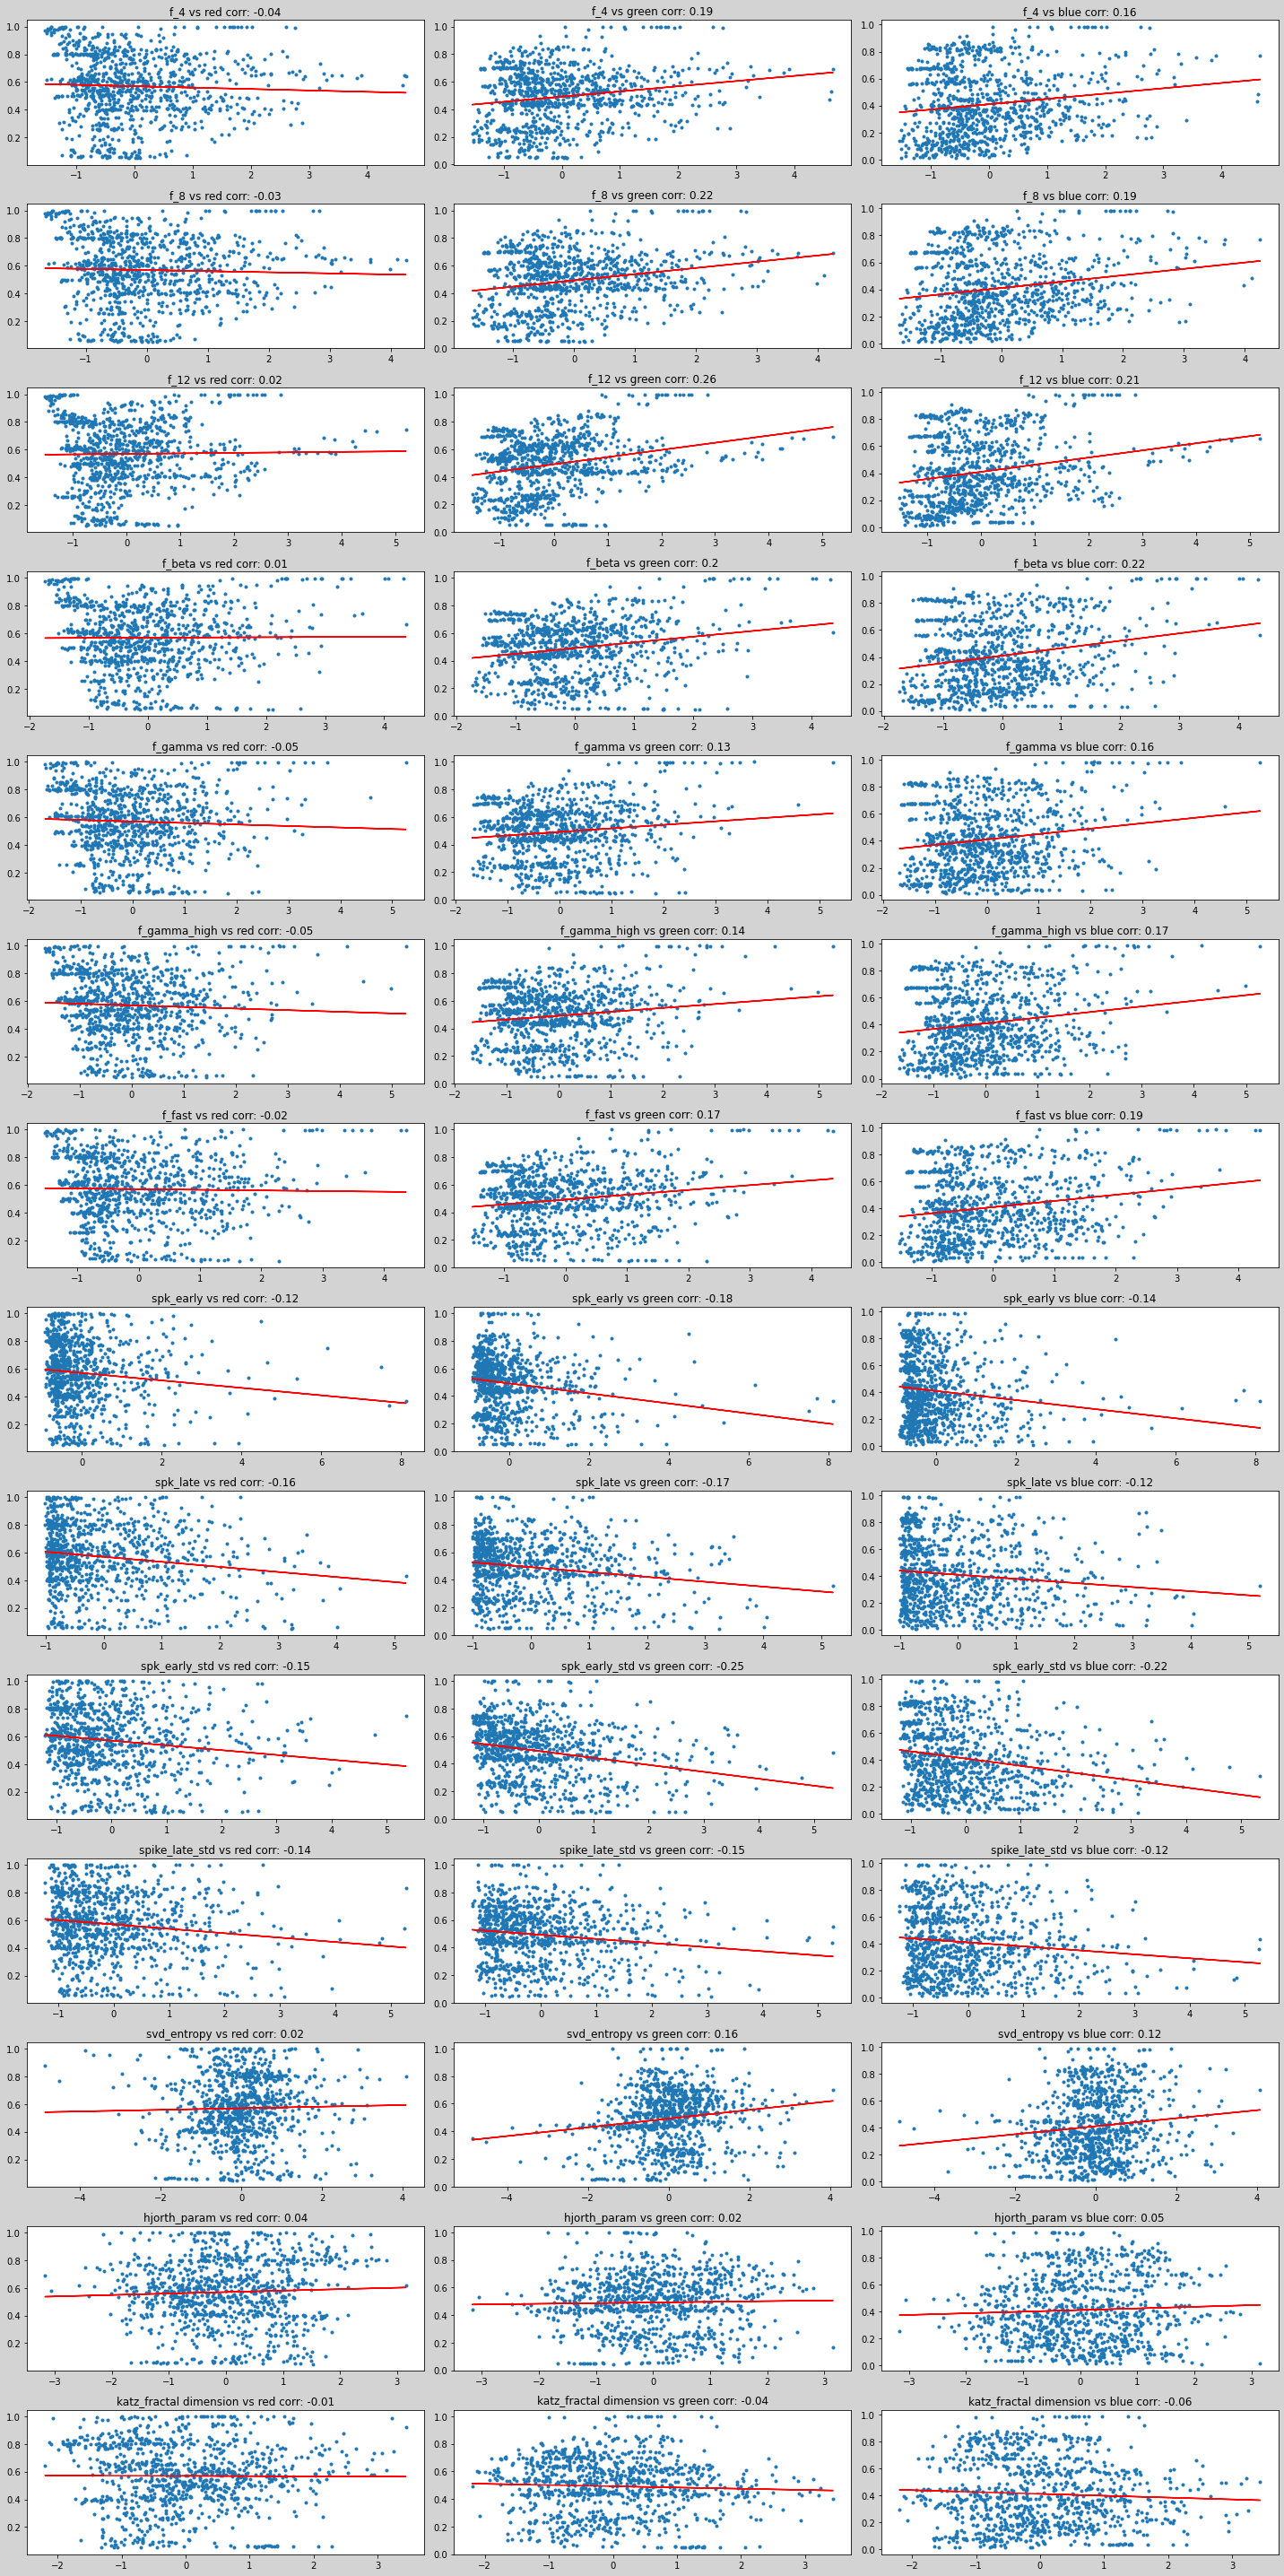

In [70]:
#lets check the correlation between all pairs of inpu and output vectors
input_dict={0:'f_4',1:'f_8',2:'f_12',3:'f_beta',4:'f_gamma',5:'f_gamma_high',6:'f_fast',7:'spk_early',8:'spk_late',9:'spk_early_std',10:'spike_late_std',11:'svd_entropy',12:'hjorth_param',13:'katz_fractal dimension'}
output_dict={0:'red',1:'green',2:'blue'}
fig,ax=plt.subplots(input_to_nn.shape[-1],output_to_nn.shape[-1])
fig.set_size_inches(20, 40)
fig.set_facecolor('lightgray')
fig.set_dpi=2000
#set tight
def func_fit(x,a,b):
        return a*x+b
for i in range(input_to_nn.shape[-1]):
    for j in range(output_to_nn.shape[-1]):
        x=input_to_nn[:,i]
        y=output_to_nn[:,j]
        correlation=np.corrcoef(x,y)[0,1]
        ax[i][j].scatter(x,y,marker='.')
        ax[i][j].set_title(input_dict[i]+" vs "+output_dict[j]+ ' corr: %s'%round(correlation,2))
        cfit=curve_fit(func_fit,x,y)
        ax[i][j].plot(x,func_fit(x,*cfit[0]),color='r')
plt.tight_layout()
plt.show()

In [71]:
class RGB_net(nn.Module):
    def __init__(self,sizes):
        super(RGB_net, self).__init__()
        self.fc1=nn.Linear(sizes[0],sizes[1],bias=True)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2=nn.Linear(sizes[1],sizes[2])
        nn.init.kaiming_normal_(self.fc2.weight)
        #self.fc3=nn.Linear(sizes[2],sizes[3])
        #nn.init.kaiming_normal_(self.fc3.weight)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        #x=F.sigmoid(self.fc3(x))
        return x
def trainer_for_RGB_net(net_temp,train_data, train_labels, criterion, lr=0.005, num_epochs=50000, lambda1 = 0.001,lambda2=0.001 ,record_every=1000):

    optimizer = optim.SGD(net_temp.parameters(), lr=lr)
    losses=np.zeros(num_epochs*train_data.shape[0]//record_every)
    iter=0
    for epoch in range(num_epochs//train_data.shape[0]):
        for i in range(train_data.shape[0]):
            optimizer.zero_grad()
            output=net_temp(train_data[i])
            loss=criterion(output,train_labels[i])

            if lambda1>0:
                lin_params1 = t.cat([x.view(-1) for x in net_temp.fc1.parameters()])
                loss+=lambda1++lambda1 * t.linalg.norm(lin_params1, ord=1)
            if lambda2>0:
                lin_params2 = t.cat([x.view(-1) for x in net_temp.fc2.parameters()])
                loss+=lambda2++lambda2 * t.linalg.norm(lin_params2, ord=1)

            loss.backward()
            optimizer.step()
            if iter % record_every == 0:
                loss=criterion(net_temp(train_data),train_labels)
                losses[iter//record_every]=loss.item()
                print(iter,loss.item())
            iter+=1
    return net_temp,losses

D:\CODING\projectEnvSummer\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.12258107215166092
1000 0.09930794686079025
2000 0.08515916764736176
3000 0.07534238696098328
4000 0.06871452927589417
5000 0.06428578495979309
6000 0.06029215082526207
7000 0.057790037244558334
8000 0.056077323853969574
9000 0.054400864988565445
10000 0.05321259796619415
11000 0.05234888941049576
12000 0.051399655640125275
13000 0.050692517310380936
14000 0.050093721598386765
15000 0.04944930225610733
16000 0.04890989884734154
17000 0.04845498874783516
18000 0.04794535040855408
19000 0.04747923091053963
20000 0.047104667872190475
21000 0.0466584786772728
22000 0.04626614600419998
23000 0.04597606137394905
24000 0.045556601136922836
25000 0.04521927237510681
26000 0.044960953295230865
27000 0.04458196461200714
28000 0.04430600628256798
29000 0.044060107320547104
30000 0.0437692254781723
31000 0.04353954270482063
32000 0.04333173856139183
33000 0.043084997683763504
34000 0.04290372505784035
35000 0.04272158071398735
36000 0.04248758777976036
37000 0.04231135919690132
38000 0.04214658

C:\Users\Sudhanshu\AppData\Local\Temp\ipykernel_18256\1321989902.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(losses_24)),np.log(losses_24))


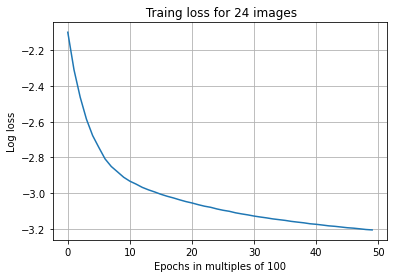

In [95]:
# we set first 24 images as the training set and the remaining as the test set
train_indices=np.arange(int(numStimulus*numElectrodes * fraction))
test_indices=np.setdiff1d(range(numStimulus*numElectrodes ), train_indices)
train_input=t.tensor(input_to_nn[train_indices, :]).float()
train_output=t.tensor(output_to_nn[train_indices, :]).float()
test_input=t.tensor(input_to_nn[test_indices, :]).float()
test_output=t.tensor(output_to_nn[test_indices, :]).float()
criterion = nn.MSELoss()
net_24=RGB_net([train_input.shape[-1] ,8, train_output.shape[-1]])
rerun_net=True
if rerun_net:
    net_24,losses_24=trainer_for_RGB_net(net_24,train_input, train_output, criterion, lr=0.003, num_epochs=50000, record_every=1000,lambda1=0.0001,lambda2=0)
    plt.plot(np.arange(len(losses_24)),np.log(losses_24))
    plt.title(" Traing loss for 24 images")
    plt.xlabel("Epochs in multiples of 100")
    plt.ylabel("Log loss")
    plt.grid(True)
    plt.savefig(savepath+'losses.png')
    t.save(net_24.state_dict(), savepath+'/nn_model.pt')
    plt.show()
else:
    net_24.load_state_dict(t.load(savepath+'/nn_model.pt'))
    net_24.eval()


In [96]:
pred_output=net_24(test_input)
print(np.round(criterion(pred_output, test_output).detach().numpy(), 4), end='\t')
pred_out=pred_output.detach().numpy()
test_out=test_output.detach().numpy()
print(np.round(np.corrcoef(pred_out.flatten(),test_out.flatten())[0,1],2),end='\t')
print(np.round(np.corrcoef((pred_out[:,0]).flatten(),(test_out[:,0]).flatten())[0,1],2),end=' ')
print(np.round(np.corrcoef((pred_out[:,1]).flatten(),(test_out[:,1]).flatten())[0,1],2),end=' ')
print(np.round(np.corrcoef((pred_out[:,2]).flatten(),(test_out[:,2]).flatten())[0,1],2),end='\n')
train_out=net_24(train_input).detach().numpy()
#now lets save the network
np.savez_compressed(savepath +'/nn_model_data.npz', train_indices=train_indices,test_indices=test_indices, pred_out=pred_out, test_out=test_out)

0.0602	0.16	0.34 0.06 0.09


In [98]:
#using the RF details and the ouptut of the network, we can now generate the RFs
predicted_RGB=np.concatenate((train_out[:,:3],pred_out[:,:3]),axis=0)
predicted_RGB=np.reshape(predicted_RGB,(numStimulus,numElectrodes,3))

In [99]:

def twoDellipse_maker(grid,x_0,y_0,sigma_x,sigma_y,RGB,numElectrodes,A=1,x_min=0,x_max=1280,y_min=0,y_max=720):

    for y_pix in prange(y_min,y_max):
        for x_pix in prange(x_min,x_max):
            count=0
            for i in range(numElectrodes):
                x = x_pix - x_0[i]
                y = y_pix - y_0[i]
                if(x<-sigma_x[i] or x>sigma_x[i] or y<-sigma_y[i] or y>sigma_y[i]):
                    continue
                elif  ((x/sigma_x[i])**2 + (y/sigma_y[i])**2) <= 1:
                    count+=1
                    grid[:,y_pix,x_pix] += RGB[:,i]
            if count>0:
                grid[:,y_pix,x_pix] = grid[:,y_pix,x_pix]/count*A



def makeImagefromRGB_patches(rfStatistics,imageDims,RGB_predictions,monitorSpecifications=None,viewingDistanceCM=50,RFtype="ellipse",electrodelist=None,savepath=None,stimlist=None):
    numStimulus = len(stimlist)
    numElectrodes = len(electrodelist)
    if monitorSpecifications is None:
        monitorSpecifications = {"height": 11.8, "width": 20.9, "xRes": 1280, "yRes": 720}
    inputImage=np.zeros(shape=imageDims)
    [xAxisDeg, yAxisDeg] = getImageInDegrees(inputImage, monitorSpecifications,viewingDistanceCM)
    xResDeg = xAxisDeg[1] - xAxisDeg[0]
    yResDeg = yAxisDeg[1] - yAxisDeg[0]
    patches = np.zeros((numStimulus,imageDims[0],imageDims[1],imageDims[2]))
    xCenterPos=np.zeros(numElectrodes)
    yCenterPos=np.zeros(numElectrodes)
    sigma_x=np.zeros(numElectrodes)
    sigma_y=np.zeros(numElectrodes)
    for j in range (numElectrodes):
            rfTMP = rfStatistics[electrodelist[j]]
            mAzi = np.squeeze(rfTMP["meanAzi"])
            mEle = np.squeeze(rfTMP["meanEle"])
            xCenterPos[j] = int(np.argwhere(xAxisDeg >= mAzi)[0][0])
            yCenterPos[j] = int(np.argwhere(yAxisDeg >= -mEle)[0][0])
            if RFtype=="ellipse":
                    sigma_x[j]=np.squeeze(rfTMP["rfSizeAzi"]/xResDeg)
                    sigma_y[j]=np.squeeze(rfTMP["rfSizeEle"]/yResDeg)
    min_x,max_x,min_y,max_y=int(np.min(xCenterPos-sigma_x)),int(np.max(xCenterPos+sigma_x)),int(np.min(yCenterPos-sigma_y)),int(np.max(yCenterPos+sigma_y))

    twoDellipse_maker(patches,xCenterPos,yCenterPos,sigma_x,sigma_y,RGB_predictions,numElectrodes,x_min=min_x,x_max=max_x,y_min=min_y,y_max=max_y)

    return patches[:,min_y-1:max_y+1,min_x-1:max_x+1]

patches_unicolour=makeImagefromRGB_patches(rfStatistics=rfStats,imageDims=[720,1280,3],stimlist=stimValsToUse,electrodelist=best_electrodes,RGB_predictions=image_e_averageRGB[:,:,:3])
patches_pred=makeImagefromRGB_patches(rfStatistics=rfStats,imageDims=[720,1280,3],stimlist=stimValsToUse,electrodelist=best_electrodes,RGB_predictions=predicted_RGB)

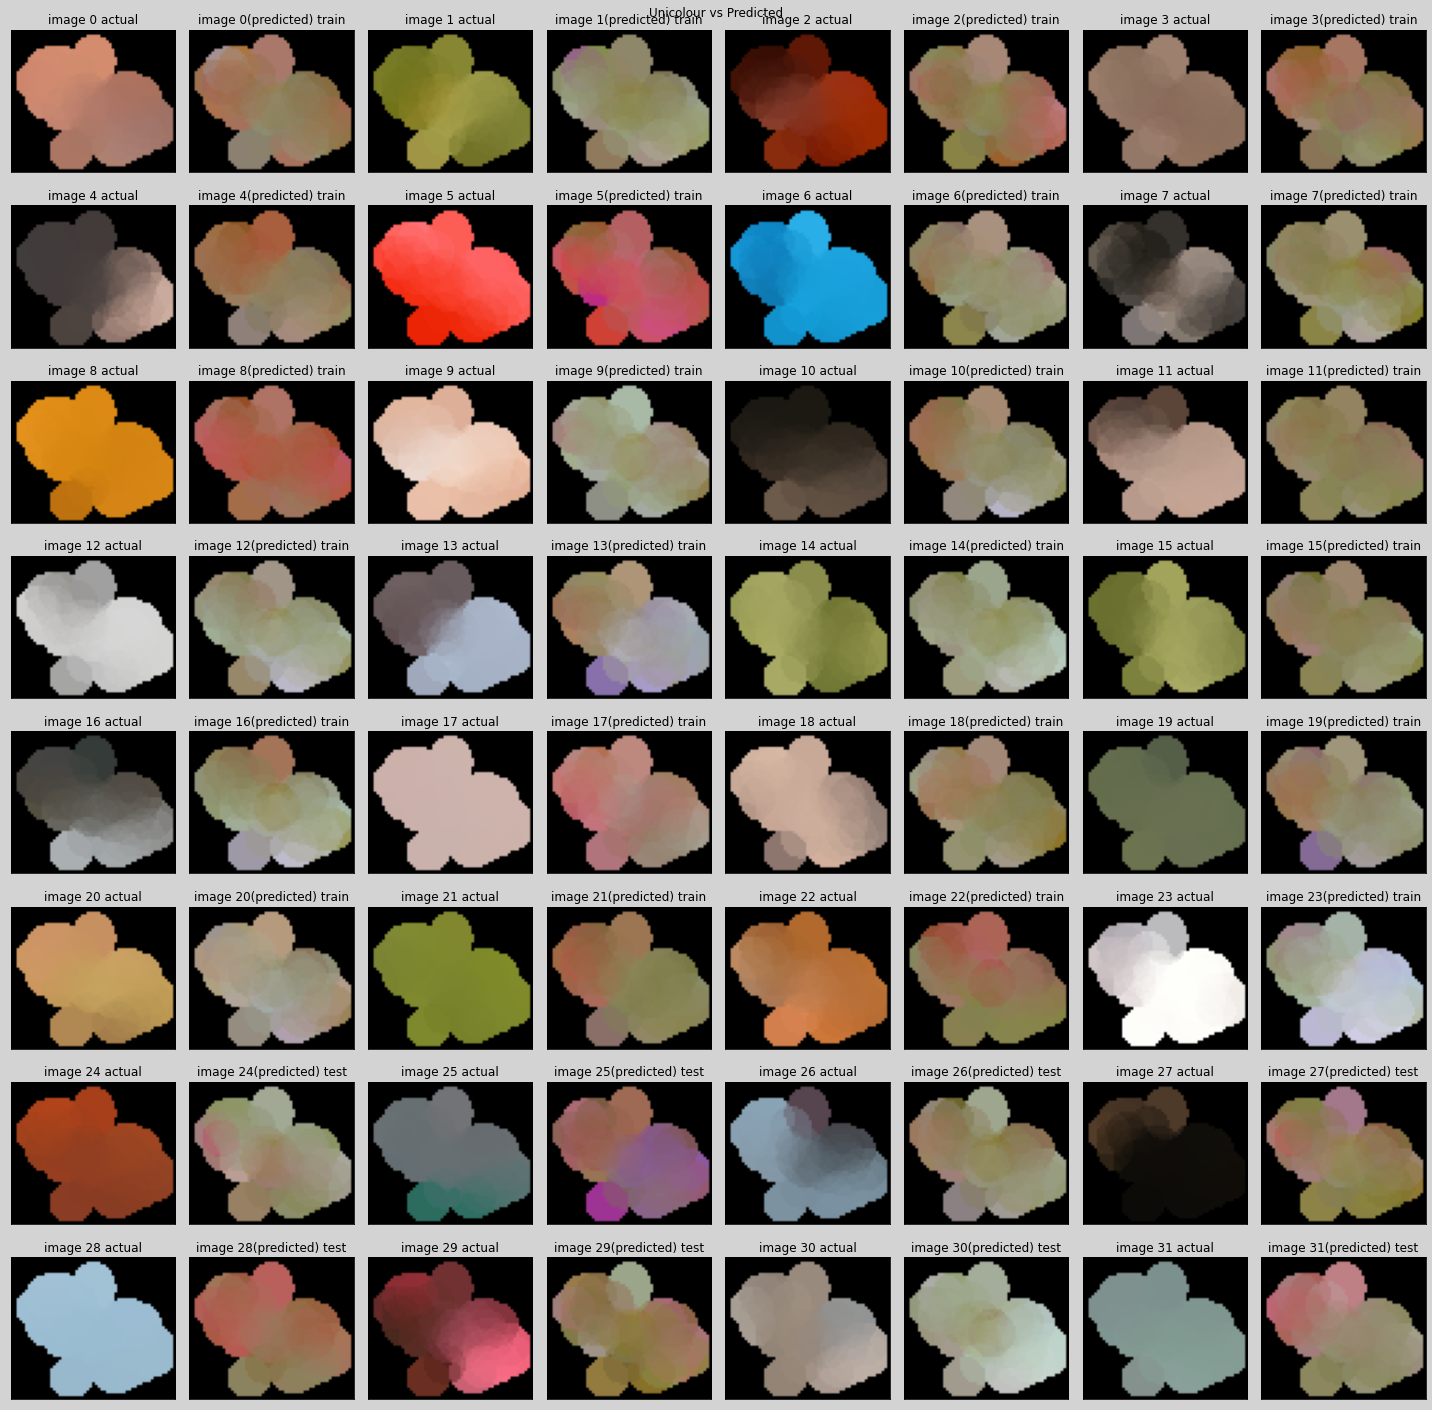

In [100]:

def rate_images(images_to_show1,images_to_show2,name ,is_hsv=False):
    fig, ax = plt.subplots(8,8)
    fig.set_size_inches(20, 20)
    fig.set_facecolor('lightgray')
    fig.set_dpi=20000
    fig.suptitle(name)
    ax = ax.flatten()
    for i in range(int(ax.size/2)):
        axis=ax[2*i]
        axis1=ax[2*i+1]
        if is_hsv:
            axis.imshow(color_tools.hsv2rgb(images_to_show1[i]))
            axis1.imshow(color_tools.hsv2rgb(images_to_show2[i]))
        axis.imshow(images_to_show1[i])
        axis1.imshow(images_to_show2[i])
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
        axis1.get_xaxis().set_visible(False)
        axis1.get_yaxis().set_visible(False)
        add="train"
        if i>=fraction*numStimulus:
            add="test"
        axis.set_title("image "+str(i)+" actual")
        axis1.set_title("image "+str(i)+"(predicted) "+add)
    plt.tight_layout()
    plt.show()
rate_images(patches_unicolour,patches_pred,"Unicolour vs Predicted")


<BarContainer object of 31 artists>

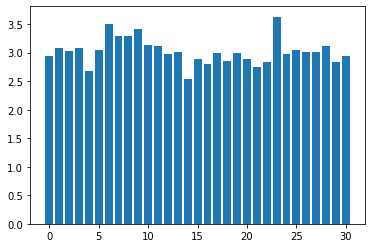

In [108]:
# let us compare how good each electrode is at predicting the colour of the image
elec_perf=np.zeros(numElectrodes)
for i in range(numElectrodes):
    # we will use the squared distance as a measure of performance
    for j in range(24,numStimulus):
        elec_perf[i]+=np.linalg.norm(image_e_averageRGB[j,i,:3]-predicted_RGB[j,i])
    elec_perf[i]=round(elec_perf[i],2)
plt.bar(np.arange(numElectrodes),elec_perf)

<BarContainer object of 31 artists>

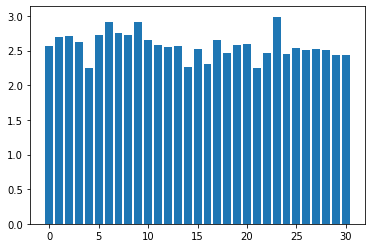